In [5]:
import warnings
warnings.filterwarnings('ignore')

### Data sample

![Alt text](image.png)![Alt text](image-1.png)

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchvision.models as models
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data, InMemoryDataset

from torch_geometric.nn import GCNConv, global_mean_pool
import torch_geometric.data
import random

from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load Mask2Former fine-tuned on Cityscapes panoptic segmentation-tiny
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-panoptic")


# load Mask2Former fine-tuned on Cityscapes panoptic segmentation-small
# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic")

# load Mask2Former fine-tuned on Cityscapes panoptic segmentation
# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")

model = model.to('cuda')

d:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
label_ids_mapping = {
    255: "ego vehicle",
    255: "rectification border",
    255: "out of roi",
    255: "static",
    255: "dynamic",
    255: "ground",
    0: "road",
    1: "sidewalk",
    255: "parking",
    255: "rail track",
    2: "building",
    3: "wall",
    4: "fence",
    255: "guard rail",
    255: "bridge",
    255: "tunnel",
    5: "pole",
    255: "polegroup",
    6: "traffic light",
    7: "traffic sign",
    8: "vegetation",
    9: "terrain",
    10: "sky",
    11: "person",
    12: "rider",
    13: "car",
    14: "truck",
    15: "bus",
    255: "caravan",
    255: "trailer",
    16: "train",
    17: "motorcycle",
    18: "bicycle"
}

In [75]:
# 加载ResNet模型
resnet = models.resnet18(pretrained=True).to(device)
resnet.eval()

# 全景分割，获得每个mask并进行嵌入
def get_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        # result = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
        result = processor.post_process_instance_segmentation(outputs)[0]

    segmentation = result["segmentation"]
    segmentation = segmentation.to(device)
    embedded_masks = []
    with torch.no_grad():
        for label_id in torch.unique(segmentation):
            mask = (segmentation == label_id).float().unsqueeze(0)  # 增加batch维度
            masked_image = mask * inputs['pixel_values']
            masked_image = masked_image.to(device)  # 确保运行在GPU上
            embedding = resnet(masked_image)
            embedded_masks.append(embedding.cpu())  # 将结果移回CPU
            
    return result, embedded_masks

# 添加类别
def label_to_onehot(label_id, num_classes=19):
    # 创建一个所有元素都是0的向量
    one_hot = np.zeros(num_classes, dtype=np.float32)
    # 在对应的类别位置上置为1
    one_hot[label_id] = 1.0
    return one_hot

# 将mask的边缘进行拓展，用于检测mask的邻接关系
def expand_mask(mask):
    expanded_mask = np.pad(mask, pad_width=1, mode='constant')
    expanded_mask = np.logical_or.reduce([
        expanded_mask[:-2, :-2],
        expanded_mask[:-2, 1:-1],
        expanded_mask[:-2, 2:],
        expanded_mask[1:-1, :-2],
        expanded_mask[1:-1, 2:],
        expanded_mask[2:, :-2],
        expanded_mask[2:, 1:-1],
        expanded_mask[2:, 2:]
    ])
    return expanded_mask

def create_single_graph(image_path, image_index, num_classes=19):
    results, embedded_masks = get_prediction(image_path)
    masks_panoptic = results["segmentation"].numpy()
    label_ids = [item["label_id"] for item in results["segments_info"]]
    G = nx.Graph()

    nodes_info = []

    for i, class_id in enumerate(np.unique(masks_panoptic)[1:]):  # 忽略背景0
        class_mask = (masks_panoptic == class_id)
        adj = expand_mask(class_mask)
        emb = embedded_masks[i]  # 假设embedded_masks按顺序对应
        label_name = label_ids_mapping.get(label_ids[i], "Unknown")
        one_hot_label = label_to_onehot(label_ids[i], num_classes=num_classes)

        node_id = (image_index, i)
        G.add_node(node_id, 
                   label=label_name, 
                   label_class=one_hot_label, 
                   embed=emb,
                   mask_adj=adj)
        nodes_info.append((node_id, adj))

    # 构建边，对原始逻辑进行调整以支持新的节点ID结构
    for i, (node_id_i, mask_i) in enumerate(nodes_info):
        for j, (node_id_j, mask_j) in enumerate(nodes_info):
            if j <= i:  # 避免重复计算和自连接
                continue
            if np.any(np.logical_and(mask_i, mask_j)):
                G.add_edge(node_id_i, node_id_j)

    return G


def create_total_graph(file_list):
    total_graph = nx.Graph()
    # 创建独立图并记录到total_graph
    graphs = []
    for image_index, image_path in enumerate(file_list):
        G = create_single_graph(image_path, image_index)
        graphs.append(G)
        for node, data in G.nodes(data=True):
            total_graph.add_node(node, **data)
        for edge in G.edges(data=True):
            total_graph.add_edge(*edge[:2], **edge[2])
    
    # 寻找并添加跨图边
    for i, G1 in enumerate(graphs):
        for j, G2 in enumerate(graphs):
            if i >= j:
                continue
            for node1, data1 in G1.nodes(data=True):
                for node2, data2 in G2.nodes(data=True):
                    # 计算余弦相似度前确保转换为Numpy数组
                    if np.array_equal(data1['label_class'], data2['label_class']):
                        embed1 = data1['embed'].detach().numpy().flatten()  # 在这里进行调整
                        embed2 = data2['embed'].detach().numpy().flatten()  # 在这里进行调整
                        similarity = 1 - cosine(embed1, embed2)
                        if similarity > 0.8:  # similarity_threshold
                            total_graph.add_edge(node1, node2, similarity=similarity)
    return total_graph


def networkx_to_pyg(G):
    node_features = []  # 存储所有节点的特征向量
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    
    # 假设所有节点的特征都已准备好并存储为 'embed' 和 'label_class'
    for node in G.nodes():
        if 'embed' not in G.nodes[node] or 'label_class' not in G.nodes[node]:
            # 创建一个与其他节点特征相同形状的零张量
            zero_feature = torch.zeros_like(node_features[0])
            node_features.append(zero_feature)
            continue
        embed = G.nodes[node]['embed'].view(1, -1).float()  # 确保embed是tensor
        label_class = torch.tensor([G.nodes[node]['label_class']], dtype=torch.float).view(1, -1)
        node_features.append(torch.cat((embed, label_class), dim=1))

    # 由节点特征列表构建特征矩阵
    x = torch.cat(node_features, dim=0)

    edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges()], dtype=torch.long).t().contiguous()
    data = Data(x=x, edge_index=edge_index)

    return data

# 设置随机种子以确保可复现性
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # 确保卷积的确定性
    torch.backends.cudnn.benchmark = False  # 如果输入数据维度或类型上变化不大,设置为False可以提高性能

# 调用函数设置随机种子
set_seed(42)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1019, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, 32)

        # 对模型进行权重初始化
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.out.reset_parameters()

    def forward(self, x, edge_index, batch_index):
        # 第一层GCN和ReLU激活函数
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        # 第二层GCN
        x = self.conv2(x, edge_index)
        # Global mean pooling
        x = global_mean_pool(x, batch_index)  # 使用global_mean_pool来得到整个图的嵌入
        # 输出层
        x = torch.nn.functional.relu(self.out(x))
        return x

def get_embedding(G):
    if G.number_of_nodes() == 0:
        print('None graph includes this road unit')
        return None
    
    g = networkx_to_pyg(G).to(device)  # 确保数据在GPU上处理
    model = GCN(hidden_channels=64).to(device)
    
    # 检查edge_index是否为空
    if g.edge_index.size(0) > 0:
        embed = model(g.x, g.edge_index, g.batch).cpu()  # 正常情况下处理
    else:
        # 处理没有边的情况
        num_features = 32  # 设置期望的节点特征维度
        embed = torch.zeros(1, num_features).cpu()  # 创建零张量作为特征
        
    return embed

In [76]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
from PIL import Image

# 假设 create_total_graph 和 get_embedding 函数已正确定义
data = pd.read_csv("E:/Dataset/project_dataset/GNN_Perception/wuhan_badu_SVI/name.csv")
df = pd.DataFrame(data)

source_folder_path = "E:/Dataset/project_dataset/GNN_Perception/wuhan_badu_SVI/baidu2023"

result_list = []

for i in tqdm(range(5075)):
    result = df[df['road_id'] == i]

    file_list = []
    for idx in result.index:
        resultssss = result.at[idx, 'Name3']
        for filename in os.listdir(source_folder_path):
            file_id = filename.split('_')[2]

            if file_id in resultssss:
                file_path = os.path.join(source_folder_path, filename)
                file_list.append(file_path)
    # print(file_list)
    if file_list:
        G = create_total_graph(file_list)
        embeddings = get_embedding(G)
        result_list.append({
            'road_id': i,
            'embeddings': embeddings
        })

result_df = pd.DataFrame(result_list)
result_df.to_csv('E:/Dataset/project_dataset/GNN_Perception/wuhan_badu_SVI/output.csv', index=False)

  0%|          | 0/5075 [00:00<?, ?it/s]

 28%|██▊       | 1435/5075 [15:35<12:10,  4.98it/s]  

None graph includes this road unit


 53%|█████▎    | 2688/5075 [28:39<31:50,  1.25it/s]  

In [5]:
img_list = ['E:/Dataset/project_dataset/GNN_Perception/wuhan_badu_SVI/baidu2023\\0_114.2544978_30.61667094.png',
            'E:/Dataset/project_dataset/GNN_Perception/wuhan_badu_SVI/baidu2023\\1_114.2542005_30.61753509.png']

g = create_total_graph(img_list)

In [39]:
get_embedding(g)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.1535, 0.0000, 0.0000, 0.0000, 0.6107,
         0.8768, 2.5214, 0.9517, 0.0553, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0673, 0.0000, 0.3721, 0.0000, 0.8217, 0.0000, 0.8355, 0.0000, 0.2310,
         0.0000, 0.7839, 0.8138, 0.0000, 0.0045]], grad_fn=<ReluBackward0>)

In [38]:
G

Data(x=[32, 1019], edge_index=[2, 68])

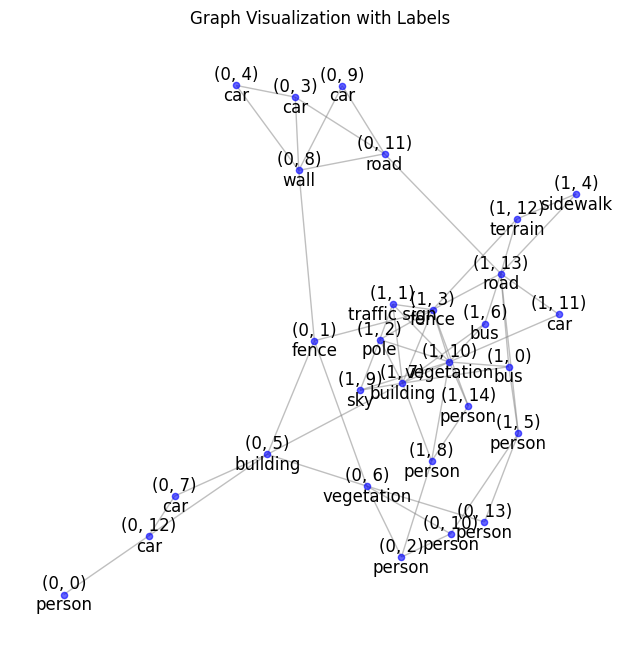

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# 假设total_graph是你的大图对象
def visualize_graph(G):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, iterations=500)  # 为图G生成一个布局
    
    # 绘制节点
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color="blue", alpha=0.6)
    
    # 绘制边
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)
    
    # 绘制节点标签，仅对小图可行，大图请注释此行
    labels = {node: f"{node}\n{data.get('label', '')}" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=12)
    
    plt.title("Graph Visualization with Labels")
    plt.axis("off")  # 关闭坐标轴
    plt.show()

visualize_graph(g)

In [ ]:
# 计算节点介数中心度
betweenness_centrality = nx.betweenness_centrality(g)

# 提取节点和介数中心度
nodes = list(betweenness_centrality.keys())
centrality = list(betweenness_centrality.values())

# # 创建柱状图
# plt.bar(nodes, centrality)
# plt.xlabel('节点')
# plt.ylabel('介数中心度')
# plt.title('节点介数中心度')
# plt.show()